<img src='../../../img/EU-Copernicus-EUM_3Logos.png' alt='Logo EU Copernicus EUMETSAT' align='right' width='50%'></img>
<br>

# Polar Multi-Sensor Aerosol Optical Properties (PMAp) Product - Aerosol Optical Depth - Level 2

### About

The following module shows you the structure of `PMAp Aerosol Optical Depth Level 2` data and what information of the data files can be used in order to load, browse and visualize Aerosol Optical Depth at 550 nm.

The polar multi-sensor aerosol optical properties product (PMAp) provides information on aerosol optical depth (AOD) at 550 nm and aerosol type (fine mode, coarse mode (dust) and volcanic ash) over ocean and land surfaces. The product is generated based on the Meteosat Second Generation instrument `GOME-2` with support of information from the instruments `AVHRR` and `IASI`.

Find more information about the product in this [factsheet](https://www.eumetsat.int/media/45738).

### Basic Facts

> **Spatial resolution**: `Metop-A: 5km x 40 km`, `Metop-B: 10km x 40 km` <br>
> **Spatial coverage**: `Global` <br>
> **Data availability**: `since February 2014`


### How to access the data

PMAp data can be ordered via the `EUMETSAT Data Centre`, which you can access via the [EUMETSAT Earth Observation Portal](https://eoportal.eumetsat.int/). If you do not have an account for the EUMETSAT EO Portal, you can create an account [here](https://eoportal.eumetsat.int/userMgmt/register.faces).  


### Module outline
- [1 - Load and browse PMAp Aerosol Optical Depth Level 2 data files](#pmap_load)
- [2 - Load multiple PMAp Level 2 data files as xarray.DataArray object](#multiple_files)
- [3 - Visualize PMAp Aerosol Optical Depth Level 2 data](#visualize)

<hr>

##### Load required libraries

In [1]:
import os
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors
import ipynb


from netCDF4 import Dataset
import pandas as pd
import glob

import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

from matplotlib.axes import Axes
from cartopy.mpl.geoaxes import GeoAxes
GeoAxes._pcolormesh_patched = Axes.pcolormesh

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action = "ignore", category = RuntimeWarning)

##### Load helper functions

In [2]:
%run ../functions.ipynb

<hr>

## <a id='pmap_load'></a>1. Load and browe PMAp Aerosol Optical Depth Level 2 data

PMAp Level 2 data is disseminated in the `NetCDF` format. You can use the [netCDF4](https://unidata.github.io/netcdf4-python/netCDF4/index.html) Python library to access and manipulate the data.

### Structure of PMAp Aerosol Optical Depth Level 2 data files

The PMAp data files are structured in 15 groups:
* `conventions`
* `Data`
* `disposition_mode`
* `keywords`
* `metadata_conventions`
* `orbit_end`
* `orbit_start`
* `organization`
* `product_level`
* `product_name`
* `sensing_end_time_utc`
* `sensing_start_time_utc`
* `spacecraft`
* `Status`
* `summary`

Most groups provide metadata information. The group of interest that contains the data itself is `Data/MeasurementData`, which has the sub-groups `GeoData` and `ObservationData`:
* `MeasurementData`
  * `GeoData`
    * **aerosol_center_latitude**
    * **aerosol_center_longitude**
    * aerosol_corner_latitude
    * aerosol_corner_longitude
    * aerosol_sensor_readout_start_time
    * cloud_center_latitude
    * cloud_center_longitude
    * cloud_corner_latitude
    * cloud_corner_longitude
    * day
    * hour
    * minute
    * month
    * year
    * ...
  * `ObservationData`
    * `Aerosol`
      * **aerosol_class**
      * **aerosol_optical_depths**
      * aerosol_retrievals_flag
      * `Auxiliary`
    * `Cloud`
      * `Auxiliary`
      * cloud_optical_depth
      * cloud_retrieval_flags
      * cloud_top_temperature
    * `QualityInformation`
      * `AVHRR`
      * `ECMWF`
      * ...


Thus, the aerosol data information can be found under the group `ObservationData/Aerosol` and the corresponding geo information under the group `GeoData/`.

### Load a PMAp Level 2 data file with the `netCDF4` library

With the `Dataset()` function of the `netCDF4` library, you can load a single file with the NetCDF format. PMAp data can be found in the folder `../../eodata/gome2/pmap/2021/02/`.

The resulting object is a `netCDF4.Dataset` object, which acts like a Python dictionary. Thus, with the `keys()` function you can list the different groups the file contains.

In [8]:
file_name = '../../../eodata/50_modules/01_dust/01_satellite/pmap/06/M02-GOME-GOMPMA02-NA-2.1-20210206164154.000000000Z-20210206182309-4753204.nc'
file = Dataset(file_name)
file.groups.keys()

dict_keys(['Data', 'Status'])

<br>

You can now select the `Data/MeasurementData/GeoData` group and get a list of available variables under this group.

In [9]:
file['Data/MeasurementData/GeoData'].variables.keys()

dict_keys(['year', 'month', 'day', 'hour', 'minute', 'aerosol_sensor_readout_start_time', 'cloud_sensor_readout_starttime', 'aerosol_corner_latitude', 'aerosol_corner_longitude', 'aerosol_center_latitude', 'aerosol_center_longitude', 'cloud_corner_latitude', 'cloud_corner_longitude', 'cloud_center_latitude', 'cloud_center_longitude', 'solar_zenith_angle', 'solar_azimuth_angle', 'platform_zenith_angle', 'platform_azimuth_angle', 'sensor_scan_angle', 'single_scattering_angle', 'relative_sensor_azimuth_angle'])

<br>

You can do the same for the group `Data/MeasurementData/ObservationData/Aerosol/`.

In [11]:
file['Data/MeasurementData/ObservationData/Aerosol'].variables.keys()

dict_keys(['aerosol_optical_depth', 'error_aerosol_optical_depth', 'aerosol_class', 'flag_ash', 'pmap_geometric_cloud_fraction', 'chlorophyll_pigment_concentration', 'aerosol_retrievals_flag'])

<br>

## <a id='multiple_files'></a>Load multiple PMAp data files as xarray.DataArray object

For easier handling and plotting of the PMAp data, you can combine geolocation information and aerosol data values in a `xarray.DataArray` structure, which can be created with the `xarray.DataArray` constructor. 

You can make use of the function [load_l2_data_xr](../functions.ipynb#load_l2_data_xr), which loads a PMAp Level 2 dataset and returns a `xarray.DataArray` with all the ground pixels of all files in a directory.

The function takes following arguments:
* `directory`: directory where the HDF file(s) are stored
* `internal_filepath`: internal path of the data variable that is of interest, e.g. Data/MeasurementData/ObservationData/Aerosol/
* `parameter`: paramter that is of interest, e.g. aerosol_optical_depth
* `lat_path`: path of the latitude variable
* `lon_path`: path of the longitude variable
* `no_of_dims`: number of dimensions of input array
* `paramname`: name of the parameter, preferable taken from the data file
* `unit`: unit of the parameter, preferably taken from the data file
* `longname`: longname of the parameter, preferably taken from the data file


Let us start with the retrieval of the `Aerosol Optical Depth` information from the data file loaded above. From there, you are able to retrieve the parameter's attributes for `Units`, `Standard_name` and `Long_name`.

In [12]:
aod = file['Data/MeasurementData/ObservationData/Aerosol/aerosol_optical_depth']
aod

<class 'netCDF4._netCDF4.Variable'>
>f8 aerosol_optical_depth(number_of_measurements)
    Units: 1
    Standard_name: aerosol_optical_depth
    Long_name: AOD_aerosol_optical_depth_at_550nm
    Comments: Aerosol Optical Depth (AOD) at 550nm
path = /Data/MeasurementData/ObservationData/Aerosol
unlimited dimensions: 
current shape = (115200,)
filling on, default _FillValue of 9.969209968386869e+36 used

The next step is to construct a `xarray.DataArray` by using the [load_l2_data_xr](../functions.ipynb#load_l2_data_xr) function. We define the objects `latpath`, `lonpath` and `internal_filepath`.

In [13]:
directory='../../../eodata/50_modules/01_dust/01_satellite/pmap/06/'

latpath='Data/MeasurementData/GeoData/aerosol_center_latitude'
lonpath='Data/MeasurementData/GeoData/aerosol_center_longitude'
internal_filepath='Data/MeasurementData/ObservationData/Aerosol'

<br>

Let us construct the DataArray object and call it `aod_xr`. The resulting object is a one-dimensional `xarray.DataArray` with more than 1.2 Mio ground pixel values and latitude and longitude as coordinate information.

In [14]:
aod_xr=load_l2_data_xr(directory=directory, 
                    internal_filepath=internal_filepath,
                    parameter='aerosol_optical_depth', 
                    lat_path=latpath, 
                    lon_path=lonpath, 
                    no_of_dims=1,
                    paramname=aod.Standard_name,
                    unit=aod.Units,
                    longname=aod.Long_name)

aod_xr

<xarray.DataArray 'aerosol_optical_depth' (ground_pixel: 1211136)>
array([-999.999999, -999.999999, -999.999999, ..., -999.999999,
       -999.999999, -999.999999])
Coordinates:
    latitude   (ground_pixel) float64 57.21 57.26 57.3 ... 60.69 60.69 60.7
    longitude  (ground_pixel) float64 16.06 15.92 15.78 ... -19.12 -19.2 -19.29
Dimensions without coordinates: ground_pixel
Attributes:
    long_name:  AOD_aerosol_optical_depth_at_550nm
    units:      1

<br>

## Generate a geographical subset for the Mediterranean region

Let us now create a geographic subset for the Mediterranean region. You can use the function [generate_geographical_subset](../functions.ipynb#generate_geographcial_subset) to create a subset based on latitude  and longitude information. You do not want to reassign the longitude values, e.g. to bring the values from a [0,360] grid to a [-180, 180] grid. For this reason, you set this keyword argument to `False`.

You see that the subsetting data array only has a bit more than 62.000 pixel information.

In [70]:
aod_xr_subset = generate_geographical_subset(xarray=aod_xr,
                                             latmin=30,
                                             latmax=60,
                                             lonmin=-10,
                                             lonmax=40,
                                             reassign=False)

aod_xr_subset

<xarray.DataArray 'aerosol_optical_depth' (ground_pixel: 62475)>
array([-999.999999, -999.999999, -999.999999, ..., -999.999999,
       -999.999999, -999.999999])
Coordinates:
    latitude   (ground_pixel) float64 57.21 57.26 57.3 ... 59.52 59.54 59.55
    longitude  (ground_pixel) float64 16.06 15.92 15.78 ... -9.825 -9.909 -9.992
Dimensions without coordinates: ground_pixel
Attributes:
    long_name:  AOD_aerosol_optical_depth_at_550nm
    units:      1

<br>

## <a id='visualize'></a> Visualize PMAp Aerosol Optical Depth Level 2 data

The final step is to visualize the PMAp Aerosol Optical Depth Level 2 data. Since the final data object is a one-dimensional `xarray.DataArray`, you can take advantage of the function [visualize_scatter](./functions.ipynb#visualize_scatter). The function creates a matplotlib scatter plot.

The function takes the following arguments as input:
* `xr_dataarray`: your xarray data object
* `conversion factor`: conversion factor in case the data values are very small, otherwise it is 1
* `projection`: cartopy projection
* `vmin`: minimum number on visualisation legend
* `vmax`: maximum number on visualisation legend
* `point size`: size of the marker
* `color scale`: color palette
* `unit`: unit of the variable
* `title`: long name of the variable
* `set_global`: if yes, the resulting plot will have a global coverage


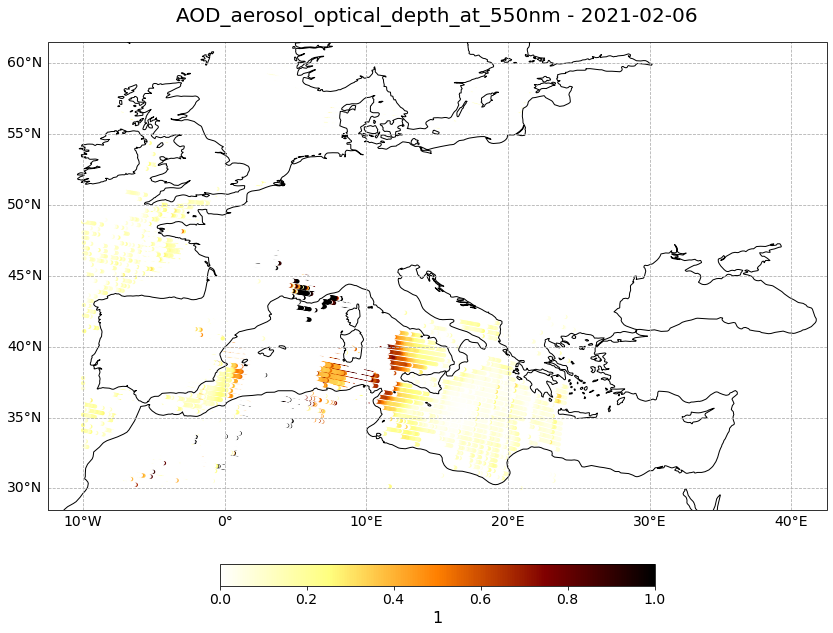

In [71]:
visualize_scatter(xr_dataarray=aod_xr_subset, 
                  conversion_factor=1, 
                  projection=ccrs.PlateCarree(),
                  vmin=0,
                  vmax=1, 
                  point_size=10,
                  color_scale='afmhot_r', 
                  unit=aod.Units, 
                  title=aod.Long_name + ' ' + '- 2021-02-06')

<hr>

<img src='../img/copernicus_logo.png' alt='Logo EU Copernicus' align='right' width='20%'><br><br><br><br>

<p style="text-align:right;">This project is licensed under the <a href="./LICENSE">MIT License</a> and is developed under a Copernicus contract.